In [1]:
import os
import keras
import numpy as np
import pandas as pd
import io
import bson
from subprocess import check_output
import multiprocessing as mp 

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
%pylab inline
from skimage.data import imread

Populating the interactive namespace from numpy and matplotlib


# Pre-processing bson input
[jump](#HERE)

In [3]:
ROOT = r"/home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/"
DATA_DIR = os.path.join(ROOT, "data/")

categories_path = os.path.join(DATA_DIR, "category_names.csv")

In [51]:
categories_df = pd.read_csv(categories_path, index_col="category_id")

In [57]:
# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)
categories_df.to_csv("data/categories.csv", index=False)
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [144]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [145]:
cat2idx, idx2cat = make_category_tables()

In [81]:
from tqdm import *

In [128]:
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length
            # print type(item_data)

            item = bson.BSON(item_data).decode()
            
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [129]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|██████████| 7069896/7069896 [05:30<00:00, 21406.38it/s]


CPU times: user 3min 1s, sys: 46.4 s, total: 3min 47s
Wall time: 5min 46s


In [132]:
train_offsets_df.to_csv("train_offsets.csv")

In [137]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [141]:
from collections import defaultdict

In [146]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

In [147]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2, drop_percentage=0)

7069896it [00:09, 773498.23it/s]
100%|██████████| 7069896/7069896 [06:36<00:00, 17824.28it/s]


In [148]:
train_images_df.head()

,product_id,category_idx,img_idx
0,36254,619,0
1,42537,619,0
2,55264,619,0
3,114584,619,0
4,123420,619,0


In [149]:
val_images_df.head()

,product_id,category_idx,img_idx
0,104035,619,0
1,121156,619,0
2,121156,619,1
3,276690,619,0
4,311733,619,0


In [150]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

('Number of training images:', 9903115)
('Number of validation images:', 2468178)
('Total images:', 12371293)


In [151]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

(5270, 5270)

In [152]:
train_images_df.to_csv("data/train_images.csv", index=False)
val_images_df.to_csv("data/val_images.csv", index=False)

# HERE

In [3]:
import tensorflow as tf

In [18]:
from tensorflow.python.framework.ops import convert_to_tensor
from tensorflow import data
from tensorflow.python.framework import dtypes

In [ ]:
img_paths = convert_to_tensor(self.img_paths, dtype=dtypes.string)

In [22]:
dataset

<TextLineDataset shapes: (), types: tf.string>

In [61]:
with tf.device("/cpu:0"):

    dataset = data.TextLineDataset("data/train_images.csv").skip(1)
    iterator = dataset.make_initializable_iterator()
    record_defaults = [[1], [1], [1]]
    
    product_id, category_idx, img_idx = tf.decode_csv(iterator.get_next(), record_defaults=record_defaults)
    features = tf.stack([product_id, category_idx, img_idx])
    

In [62]:
sess = tf.InteractiveSession()

In [63]:
# Initialize an iterator over a dataset with 10 elements.
sess.run(iterator.initializer)
sess.run(features)

array([36254,   619,     0], dtype=int32)

In [110]:
categories_df = pd.read_csv("data/categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
0,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
2,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
3,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
4,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [49]:
train_images_df = pd.read_csv("data/train_images.csv")

In [57]:
train_images_df = train_images_df.astype(np.int32)
train_images_df.info()
# train_images_df.to_csv('data/train_images.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9903115 entries, 0 to 9903114
Data columns (total 3 columns):
product_id      int32
category_idx    int32
img_idx         int32
dtypes: int32(3)
memory usage: 113.3 MB


In [162]:
val_images_df.head()

,product_id,category_idx,img_idx
0,104035,619,0
1,121156,619,0
2,121156,619,1
3,276690,619,0
4,311733,619,0


In [65]:
train_offsets_df = pd.read_csv("data/train_offsets.csv")

In [64]:
bson = open("data/train.bson")

In [98]:
record

,product_id,num_imgs,offset,length,category_id
26456,36254,1,231441971,5760,1000005633


In [99]:
record = train_offsets_df[train_offsets_df.product_id==36254]
offset = record.offset.values[0]
length = record.length.values[0]
img_idx = record.num_imgs.values[0]

In [82]:
bson.seek(offset)

In [83]:
sample = bson.read(length)

In [91]:
import bson

In [92]:
item = bson.BSON(sample).decode()

In [107]:
pic = imread(io.BytesIO(item['imgs'][img_idx-1]['picture']))

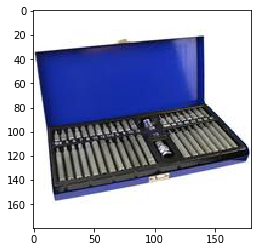

In [108]:
imshow(pic)

In [111]:
categories_df[categories_df.category_idx==1000005633]

,category_level1,category_level2,category_level3,category_idx
